# TITANIC

## Wstęp

W tym projekcie postaram się przeanalizować zbiór danych reprezentujący pasażerów uczestniczących w tragicznym rejsie Titanica. Statku nazwanego niezatapialnym, który zatanął podczas swojego dziewiczego rejsu po zderzeniu z górą lodową. 

Postaram się sprawdzić jakie czynniki, mogły zwiększyć bądź zmniejszyć szansę przeżycia pasażerów. Analizowany zbiór zawiera następujące kolumny:

- Id Pasażera
- Czy pasażer przeżył
- Klasę jaką podróżował
- Imię i Nazwisko
- Płeć
- Wiek
- Relacje rodzinne(Mąż, Żona, Syn, Córka, Mąż, Żona, Brat, Siostra)
- Bilet
- Wysokość opłaty
- Numer kabiny
- Kod portu

## Plan analizy

W swojej pracy przeanalizuję wszystkie kolumny i sprawdzę jaki dana kolumna miałą wpływ na przeżywalność pasażerów. W międzyczasie w przypadku brakujących wartości zdecyduję czy dana kolumna będzie brała udział w dalszej analizie czy powinna zostać usunięta.

Następnie wybrane w czasie analizy kolumny uwzględnimy w modelu regresji logistycznej. Zbiór titanic_train będzie służył do uczenia naszego modelu, aby następnie przypisać wartości dla atrybutów zbioru titanic_test. NAstepnie podzielimy zbiór titanic_train na zbiór treningowy i testowy, aby sprawdzić skuteczność zbudowanego modelu



In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [274]:
tit_test = pd.read_csv('titanic_test.csv')

In [275]:
tit_train = pd.read_csv('titanic_train.csv')

In [276]:
tit_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


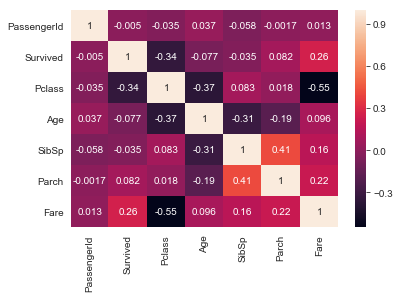

In [277]:
sns.heatmap(tit_train.corr(), annot=True)

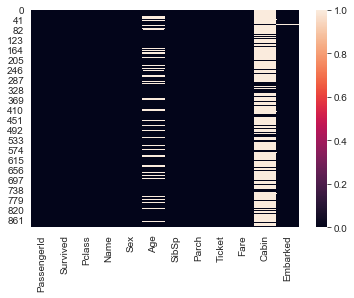

In [278]:
sns.heatmap(tit_train.isnull())

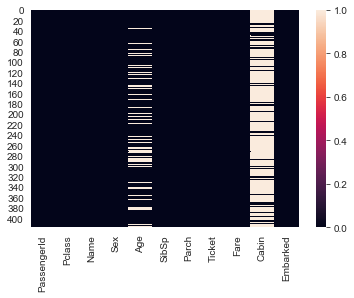

In [279]:
sns.heatmap(tit_test.isnull())

Jak widzimy wystepuje wiele wartości Null/NaN, w jakis sposób trzeba sobie z tym poradzić. Mozliwe rozwiązanie to ustawienie średnego wieku np po płci natomiast kolumnę Cabin można usunąć, albo po prostu ustawić inną wartość zamiast Null/NaN

Teraz przeanalizujemy kolejne kolumny pod względem przydatności w naszym modelu 

In [280]:
tit_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Jak widzimy przeżyło tylko ok. 38% pasażerów

In [281]:
tit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Teraz przeanalizujemy kolejne kolumny pod kątem przeżywalności pasażerów i zdecydujemy które z nich uwzględnić w naszym modelu.

Na początku przeanalizujemy klasy jakimi podróżowali pasażerowie

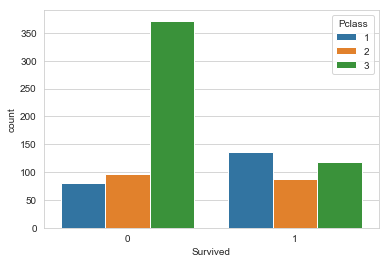

In [282]:
sns.countplot(data=tit_train, x='Survived', hue='Pclass')

In [283]:
tit_train.groupby('Pclass', as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Pasażerowie z pierwszej klasy mieli większe szanse na przeżycie, około 63% z nich przeżyło wypadek, ponadto im lepsza klasa, tym więcej pasażerów przeżyło wypadek - Uwzględniamy Pclass w naszym modelu

Teraz przejdziemy do analizy płci pasażerów

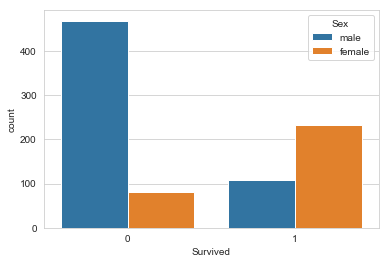

In [284]:
sns.countplot(data=tit_train, x='Survived', hue='Sex')

In [285]:
tit_train.groupby('Sex', as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Jak widać na wykresie oraz w przedstawionej tabelce, około 74% kobiet przezyło wypadek, natomiast ocalonych mężczyzn było tylko niecałe 19%. Zapewne wynikało to z zasady ratowania najpeirw kobiet i dzieci. O słuszności tej hipotezy przekonamy się także przy analizie wieku pasażerów

Teraz zamienimy wartości tekstowe na numeryczne abysmy mogli uwzględnić je w naszym modelu regresji logistycznej

In [286]:
sex_train = pd.get_dummies(tit_train['Sex'],  drop_first=True)
tit_train = pd.concat([tit_train, sex_train], axis=1)
tit_train.drop('Sex', axis=1, inplace=True)

sex_test = pd.get_dummies(tit_test['Sex'],  drop_first=True)
tit_test = pd.concat([tit_test, sex_test], axis=1)
tit_test.drop('Sex', axis=1, inplace=True)

#### Teraz zamienimy wartości w 'Embarked' na wartości liczbowe

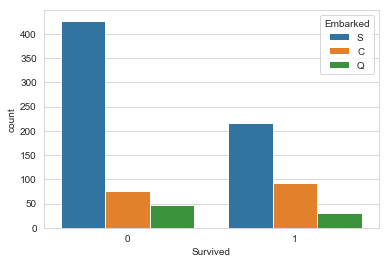

In [287]:
sns.countplot(data=tit_train, x='Survived', hue='Embarked')

In [288]:
tit_train.groupby('Embarked', as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [289]:
tit_train.Embarked[tit_train['Embarked'] == 'C'] = 1
tit_train.Embarked[tit_train['Embarked'] == 'S'] = 2
tit_train.Embarked[tit_train['Embarked'] == 'Q'] = 3
tit_test.Embarked[tit_test['Embarked'] == 'C'] = 1
tit_test.Embarked[tit_test['Embarked'] == 'S'] = 2
tit_test.Embarked[tit_test['Embarked'] == 'Q'] = 3

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\acer\Anaconda

In [290]:
tit_train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,2,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,2,1


#### W dalszej części analizy wypełnimy wartości Null/NaN w kolumnie 'Cabin'. Zastepimy je wartością 'NO'

In [291]:
tit_train['Cabin'].fillna('N0', inplace=True)
tit_test['Cabin'].fillna('N0', inplace=True)

In [292]:
cabin_letter_train = tit_train['Cabin'].apply(lambda x: x[0])
cabin_letter_train.head()

0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object

In [293]:
cabin_letter_test = tit_test['Cabin'].apply(lambda x: x[0])
cabin_letter_test.head()

0    N
1    N
2    N
3    N
4    N
Name: Cabin, dtype: object

In [294]:
tit_train.drop('Cabin', axis=1, inplace=True)
tit_test.drop('Cabin', axis=1, inplace=True)

In [295]:
tit_train = pd.concat([tit_train, cabin_letter_train], axis=1)
tit_test = pd.concat([tit_test, cabin_letter_test], axis=1)

In [296]:
tit_train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Cabin
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,2,1,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,C
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,2,0,N
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2,0,C
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,2,1,N


In [297]:
print(tit_train.groupby('Cabin', as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False))

  Cabin  Survived
3     D  0.757576
4     E  0.750000
1     B  0.744681
5     F  0.615385
2     C  0.593220
6     G  0.500000
0     A  0.466667
7     N  0.299854
8     T  0.000000


In [298]:
print(tit_train.groupby('Cabin', as_index=False)['Survived'].count().sort_values(by='Survived', ascending=False))
print(tit_test.groupby('Cabin', as_index=False)['Fare'].count().sort_values(by='Fare', ascending=False))

  Cabin  Survived
7     N       687
2     C        59
1     B        47
3     D        33
4     E        32
0     A        15
5     F        13
6     G         4
8     T         1
  Cabin  Fare
7     N   326
2     C    35
1     B    18
3     D    13
4     E     9
5     F     8
0     A     7
6     G     1


#### Jak widzimy Pasażerowie z kabin D, E, B, F, C mieli większą szansę na przeżycie niż pozostali. Chociaż statystyka jest niepełna uwzględnimy tę kolumnę w naszym modelu. T zamienimy na N gdyż nie wystepuje ona w zbiorze testowym a pasażer i tak zginął

In [299]:
tit_train.Cabin[tit_train['Cabin']=='T']='N'

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [300]:
def cabin_to_number(cabin_letter):
    if cabin_letter == 'N':
        return 0
    elif cabin_letter =='C':
        return 1
    elif cabin_letter == 'B':
        return 2
    elif cabin_letter == 'D':
        return 3
    elif cabin_letter =='E':
        return 4
    elif cabin_letter == 'A':
        return 5
    elif cabin_letter == 'F':
        return 6
    else:
        return 7

In [301]:
tit_train['Cabin'] = tit_train['Cabin'].apply(cabin_to_number)
tit_test['Cabin'] = tit_test['Cabin'].apply(cabin_to_number)

In [302]:
tit_train.head(10)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Cabin
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,2,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,2,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,2,1,0
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,3,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,2,1,4
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,2,1,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,2,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,1,0,0


#### Analizę imion odpuścimy, gdyż uważam, że imię nie ma wpływu na to czy ktoś przeżył katastrofę

Nie będziemy dodawać oddzielnej kolumny na prefixy gdyż jest to ściśle powiązane z płcią, która już będzie częścią naszego modelu

In [303]:
tit_train.drop('Name', axis=1, inplace=True)
tit_test.drop('Name', axis=1, inplace=True)

In [304]:
tit_train.groupby('Pclass', as_index=False)['Age'].mean()

,Pclass,Age
0,1,38.233441
1,2,29.877630
2,3,25.140620


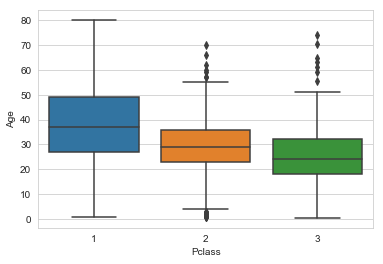

In [305]:
sns.boxplot(data=tit_train, x="Pclass", y='Age')

Dla pierwszej klasy wstawimy wartość 38, dla drugiej 30, a dla trzeciej 25

In [306]:
def fill_missing_age(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 38
        elif pclass == 2:
            return 30
        else:
            return 25
    else:
        return age

In [307]:
tit_train['Age'] = tit_train[['Age', 'Pclass']].apply(fill_missing_age, axis=1)
tit_test['Age'] = tit_test[['Age', 'Pclass']].apply(fill_missing_age, axis=1)

In [308]:
tit_train.head(10)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Cabin
0,1,0,3,22.0,1,0,A/5 21171,7.2500,2,1,0
1,2,1,1,38.0,1,0,PC 17599,71.2833,1,0,1
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,2,0,0
3,4,1,1,35.0,1,0,113803,53.1000,2,0,1
4,5,0,3,35.0,0,0,373450,8.0500,2,1,0
5,6,0,3,25.0,0,0,330877,8.4583,3,1,0
6,7,0,1,54.0,0,0,17463,51.8625,2,1,4
7,8,0,3,2.0,3,1,349909,21.0750,2,1,0
8,9,1,3,27.0,0,2,347742,11.1333,2,0,0
9,10,1,2,14.0,1,0,237736,30.0708,1,0,0


In [309]:
tit_train.dropna(inplace=True)

#### Teraz przeanalizujemy wiek ocalonych, sprawdzimy ile osób z róznych grup wiekowych przeżyło wypadek

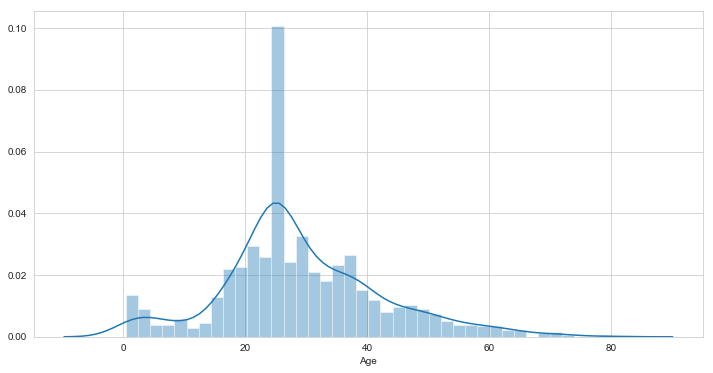

In [310]:
plt.figure(figsize=(12,6))
sns.distplot(tit_train['Age'], bins=40)

C:\Users\acer\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


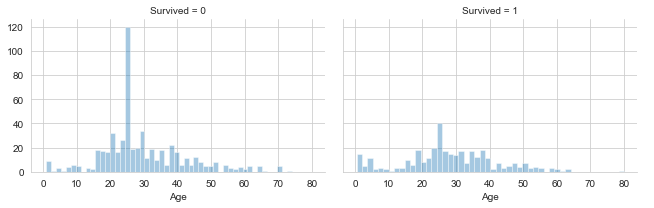

In [311]:
grid = sns.FacetGrid(data = tit_train, col='Survived', size=3, aspect=1.5)
grid.map(sns.distplot, 'Age', kde=False, bins=50)
grid.add_legend()

Bazując na powyższych wynikach, podzielimy wiek pasażerów na nastepujące przedziały:  
1. małe dzieci - (0,6)
2. dzieci - (7,12)
3. młodzież - (13,20)
4. młodzi dorośli - (21, 40)
5. starsi dorośli - (41,60)
6. emeryci - (60 - 80)

In [312]:
bins = [0, 6, 12, 20, 40, 60, 80]
tit_train['Age_cut'] = pd.cut(tit_train['Age'], bins)
tit_test['Age_cut'] = pd.cut(tit_test['Age'], bins)

print(tit_train['Age_cut'].value_counts())
print(tit_test['Age_cut'].value_counts())
tit_train[['Age_cut', 'Survived']].groupby(['Age_cut'], as_index=False).mean().sort_values(by='Survived', ascending=False)

(20, 40]    561
(40, 60]    128
(12, 20]    110
(0, 6]       47
(6, 12]      22
(60, 80]     21
Name: Age_cut, dtype: int64
(20, 40]    272
(40, 60]     66
(12, 20]     44
(0, 6]       15
(60, 80]     11
(6, 12]      10
Name: Age_cut, dtype: int64


,Age_cut,Survived
0,"(0, 6]",0.702128
4,"(40, 60]",0.390625
2,"(12, 20]",0.381818
3,"(20, 40]",0.363636
1,"(6, 12]",0.318182
5,"(60, 80]",0.190476


#### Jak widzimy wyniki dla Mlodzieży, Młodych i starszych dorosłych są bardzo zblizone więc zamkniemy je w jednym przedziale

In [313]:
bins = [0, 6, 12, 60, 80]
tit_train['Age_cut'] = pd.cut(tit_train['Age'], bins)
tit_test['Age_cut'] = pd.cut(tit_test['Age'], bins)

print(tit_train['Age_cut'].value_counts())
print(tit_test['Age_cut'].value_counts())
tit_train[['Age_cut', 'Survived']].groupby(['Age_cut'], as_index=False).mean().sort_values(by='Survived', ascending=False)

(12, 60]    799
(0, 6]       47
(6, 12]      22
(60, 80]     21
Name: Age_cut, dtype: int64
(12, 60]    382
(0, 6]       15
(60, 80]     11
(6, 12]      10
Name: Age_cut, dtype: int64


,Age_cut,Survived
0,"(0, 6]",0.702128
2,"(12, 60]",0.370463
1,"(6, 12]",0.318182
3,"(60, 80]",0.190476


In [314]:
def swap_intervals(value):
    if str(value) == '(0, 6]':
        return 0
    elif str(value) == '(6, 12]':
        return 1
    elif str(value) == '(12, 60]':
        return 2
    else:
        return 3

In [315]:
tit_train['Age_cut'] = tit_train['Age_cut'].apply(swap_intervals)
tit_test['Age_cut'] = tit_test['Age_cut'].apply(swap_intervals)


In [316]:
tit_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Cabin,Age_cut
0,1,0,3,22.0,1,0,A/5 21171,7.2500,2,1,0,2
1,2,1,1,38.0,1,0,PC 17599,71.2833,1,0,1,2
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,2,0,0,2
3,4,1,1,35.0,1,0,113803,53.1000,2,0,1,2
4,5,0,3,35.0,0,0,373450,8.0500,2,1,0,2


#### Teraz podobnie postąpimy z ceną biletu. Przypuszczamy, że osoby z droższymi biletami miały lepsze miejsca i dzięki temu np. łatwiejszą drogę ewakuacji.

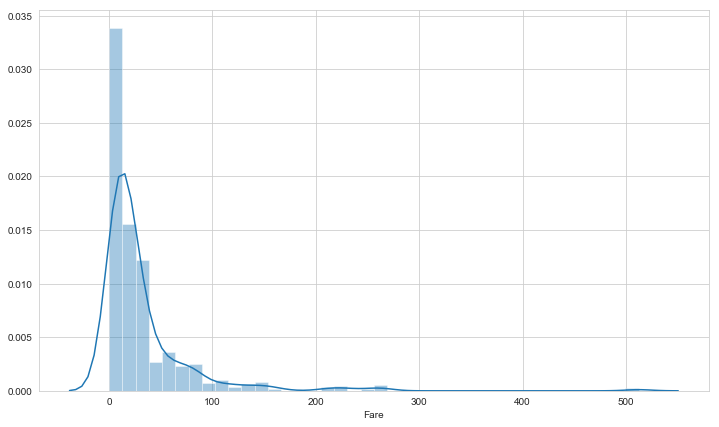

In [317]:
plt.figure(figsize=(12,7))
sns.distplot(tit_train['Fare'], bins=40)

#### Spróbujemy podzielić ceny biletów na przedziały: 
1. Bardzo Tani - (0,50)
2. Tani - (50,100)
3. Średni - (100,200)
4. Drogi - (200-300)
5. Ekskluzywny - (300,max) 

In [318]:
tit_train['Fare'].max()

512.3292

In [319]:
bins = [-0.01, 50, 100, 200, 300, 513]

tit_train['Fare_cut'] = pd.cut(tit_train['Fare'], bins)
tit_test['Fare_cut'] = pd.cut(tit_test['Fare'], bins)

print(tit_train['Fare_cut'].value_counts())
print(tit_test['Fare_cut'].value_counts())
tit_train[['Fare_cut', 'Survived']].groupby(['Fare_cut'], as_index=False).mean().sort_values(by='Survived', ascending=False)

(-0.01, 50.0]     731
(50.0, 100.0]     105
(100.0, 200.0]     33
(200.0, 300.0]     17
(300.0, 513.0]      3
Name: Fare_cut, dtype: int64
(-0.01, 50.0]     337
(50.0, 100.0]      49
(200.0, 300.0]     17
(100.0, 200.0]     13
(300.0, 513.0]      1
Name: Fare_cut, dtype: int64


,Fare_cut,Survived
4,"(300.0, 513.0]",1.000000
2,"(100.0, 200.0]",0.757576
1,"(50.0, 100.0]",0.647619
3,"(200.0, 300.0]",0.647059
0,"(-0.01, 50.0]",0.318741


Jak widzimy pasażerowie posiadający droższe bilety rzeczywiście mieli wieksze szanse na przezycie. Jakiekolwiek brakujące wartości uzupełniamy wartościami średnimi dla danej klasy.

Teraz dla każdego przedziału przypiszemy odpowiadający numer:

In [320]:
def fare_cut_to_number(value):
    if str(value) == '(0, 50]':
        return 0
    elif str(value) == '(50, 100]':
        return 1
    elif str(value) == '(100, 200]':
        return 2
    elif str(value) == '(200, 300]':
        return 3
    else:
        return 4

In [321]:
tit_train['Fare_cut'] = tit_train['Fare_cut'].apply(fare_cut_to_number)
tit_test['Fare_cut'] = tit_test['Fare_cut'].apply(fare_cut_to_number)

In [322]:
tit_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Cabin,Age_cut,Fare_cut
0,1,0,3,22.0,1,0,A/5 21171,7.2500,2,1,0,2,4
1,2,1,1,38.0,1,0,PC 17599,71.2833,1,0,1,2,4
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,2,0,0,2,4
3,4,1,1,35.0,1,0,113803,53.1000,2,0,1,2,4
4,5,0,3,35.0,0,0,373450,8.0500,2,1,0,2,4


#### W tej sekcji przejdziemy do analizy samych biletów. Nazwa biletu mogła determinować miejsce kabiny a więc, także drogę ewakuacji pasażera

In [323]:
tickets_len_train = tit_train['Ticket'].apply(lambda x: len(x))
tickets_len_test = tit_test['Ticket'].apply(lambda x: len(x))


In [324]:
tit_train['Ticket_len'] = tickets_len_train
tit_test['Ticket_len'] = tickets_len_test

In [325]:
print(tit_train['Ticket_len'].value_counts())
print(tit_test['Ticket_len'].value_counts())
tit_train.groupby('Ticket_len', as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

6     417
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_len, dtype: int64
6     183
5      62
4      47
8      42
10     22
9      11
11     10
13      9
7       9
18      8
12      6
15      3
17      2
16      2
3       2
Name: Ticket_len, dtype: int64


,Ticket_len,Survived
2,5,0.618321
5,8,0.539474
13,17,0.428571
9,12,0.400000
10,13,0.400000
1,4,0.366337
7,10,0.341463
11,15,0.333333
3,6,0.316547
4,7,0.296296


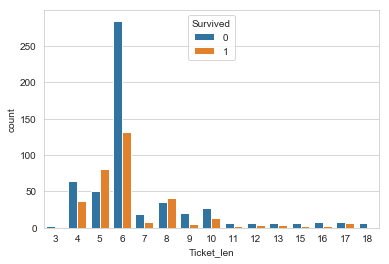

In [326]:
sns.countplot(data=tit_train, x='Ticket_len', hue='Survived')

Teraz sprawdzimy jaki wpływ miał pierwszy znak w nazwie biletu

In [327]:
ticket_start_train = tit_train['Ticket'].apply(lambda x: x[0])
ticket_start_test = tit_test['Ticket'].apply(lambda x: x[0])

In [328]:
tit_train['Ticket_start'] = ticket_start_train
tit_test['Ticket_start'] = ticket_start_test

In [329]:
print(tit_train['Ticket_start'].value_counts())
print(tit_test['Ticket_start'].value_counts())
tit_train.groupby('Ticket_start', as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

3    301
2    183
1    144
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_start, dtype: int64
3    128
2     95
1     64
S     33
P     33
C     30
A     13
F      6
W      6
7      4
6      3
9      1
4      1
L      1
Name: Ticket_start, dtype: int64


,Ticket_start,Survived
8,9,1.000000
13,P,0.646154
0,1,0.625000
11,F,0.571429
1,2,0.464481
10,C,0.340426
14,S,0.323077
12,L,0.250000
2,3,0.239203
3,4,0.200000


#### Jak widzimy wartości jest bardzo dużo, więc cały zbiór postaramy się trochę uszczuplić.

Przede wszystkim prefixy o niskiej częstotliwości wystepowania podzielimy na takie które były związanie z dużą przeżywalnością i na takie które były związane z małą przezywalnością posiadających bilet z danym prefixem pasażerów

In [330]:
tit_train['Ticket_start'] = tit_train['Ticket_start'].replace(['W', '4', '7', '6', 'L', '5', '8'], 'Rare_Low_Surv')
tit_train['Ticket_start'] = tit_train['Ticket_start'].replace(['F', '9'], 'Rare_High_Surv')
tit_test['Ticket_start'] = tit_test['Ticket_start'].replace(['W', '4', '7', '6', 'L', '5', '8'], 'Rare_Low_Surv')
tit_test['Ticket_start'] = tit_test['Ticket_start'].replace(['F', '9'], 'Rare_High_Surv')
tit_train.tail()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Cabin,Age_cut,Fare_cut,Ticket_len,Ticket_start
886,887,0,2,27.0,0,0,211536,13.00,2,1,0,2,4,6,2
887,888,1,1,19.0,0,0,112053,30.00,2,0,2,2,4,6,1
888,889,0,3,25.0,1,2,W./C. 6607,23.45,2,0,0,2,4,10,Rare_Low_Surv
889,890,1,1,26.0,0,0,111369,30.00,1,1,1,2,4,6,1
890,891,0,3,32.0,0,0,370376,7.75,3,1,0,2,4,6,3


In [331]:
ticket_dummies_train = pd.get_dummies(tit_train['Ticket_start'], prefix = 'Ticket_start')
tit_train = pd.concat([tit_train.drop(['Ticket', 'Ticket_start'], axis=1), 
          ticket_dummies_train], axis=1)

ticket_dummies_test = pd.get_dummies(tit_test['Ticket_start'], prefix = 'Ticket_start')
tit_test = pd.concat([tit_test.drop(['Ticket', 'Ticket_start'], axis=1), 
          ticket_dummies_test], axis=1)

Jednym z ostatnich etapów przygotowywania i analizy naszych danych będzie sprawdzenie jaki wpływ na przeżywalność pasażerów miała ilość osób z nimi podróżująca

In [332]:
tit_train['Family'] = tit_train['SibSp'] + tit_train['Parch']
tit_test['Family'] = tit_test['SibSp'] + tit_test['Parch']

In [333]:
tit_train.groupby('Family', as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.300935
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


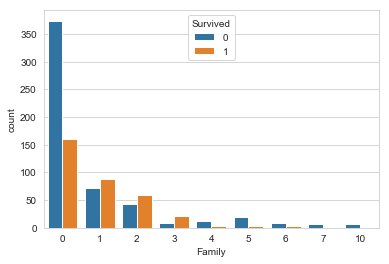

In [334]:
sns.countplot(data=tit_train, x='Family', hue='Survived')

Kolejny raz, pierwszym krokiem będzie scalenie niektórych wartości. Tutaj podzielimy to w nastepujący sposób
1. Osoby podróżujące same('Alone') - wartość 0
2. Osoby podrużujące w małej rodzinie('Little_Family') - wartości 1,2,3
3. Osoby podruzujące w dużej rodzinie('Bif_Family') - wartości > 3

In [335]:
tit_train['Family'] = tit_train['Family'].replace([0], 'Alone')
tit_train['Family'] = tit_train['Family'].replace([1, 2, 3], 'Little_Family')
tit_train['Family'] = tit_train['Family'].replace([4, 5, 6, 7, 10], 'Big_Family')

tit_test['Family'] = tit_test['Family'].replace([0], 'Alone')
tit_test['Family'] = tit_test['Family'].replace([1, 2, 3], 'Little_Family')
tit_test['Family'] = tit_test['Family'].replace([4, 5, 6, 7, 10], 'Big_Family')

In [336]:
tit_train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
2,Little_Family,0.578767
0,Alone,0.300935
1,Big_Family,0.161290


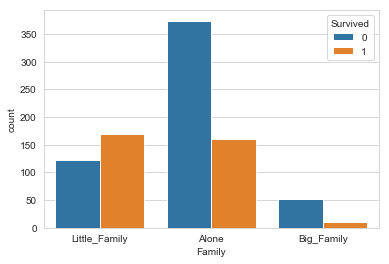

In [337]:
sns.countplot(data=tit_train, x='Family', hue='Survived')

Jak widzimy osoby podrużujące w małej rodzinie miały dużo więskze szanse na przezycie niż osoby podrużujące samotnie, oraz w duzej rodzinie

In [338]:
tit_train = pd.concat([tit_train.drop(['SibSp', 'Parch', 'Family'], axis=1), 
                                    pd.get_dummies(tit_train['Family'], prefix = 'Family')], axis=1)

tit_test = pd.concat([tit_test.drop(['SibSp', 'Parch', 'Family'], axis=1), 
                                    pd.get_dummies(tit_test['Family'], prefix = 'Family')], axis=1)

Na koniec sprawdzimy czy na pewno nie ma żadnych wartości Null/NaN

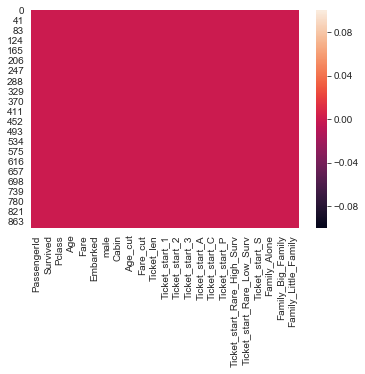

In [339]:
sns.heatmap(tit_train.isnull())

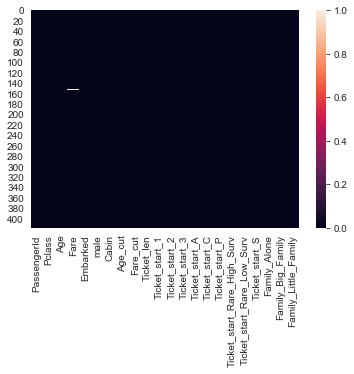

In [340]:
sns.heatmap(tit_test.isnull())

Usuwamy jedną wartość NaN

In [341]:
tit_test.dropna(inplace=True)

In [342]:
tit_train.head()

,PassengerId,Survived,Pclass,Age,Fare,Embarked,male,Cabin,Age_cut,Fare_cut,...,Ticket_start_3,Ticket_start_A,Ticket_start_C,Ticket_start_P,Ticket_start_Rare_High_Surv,Ticket_start_Rare_Low_Surv,Ticket_start_S,Family_Alone,Family_Big_Family,Family_Little_Family
0,1,0,3,22.0,7.2500,2,1,0,2,4,...,0,1,0,0,0,0,0,0,0,1
1,2,1,1,38.0,71.2833,1,0,1,2,4,...,0,0,0,1,0,0,0,0,0,1
2,3,1,3,26.0,7.9250,2,0,0,2,4,...,0,0,0,0,0,0,1,1,0,0
3,4,1,1,35.0,53.1000,2,0,1,2,4,...,0,0,0,0,0,0,0,0,0,1
4,5,0,3,35.0,8.0500,2,1,0,2,4,...,1,0,0,0,0,0,0,1,0,0


Na koniec usuniemy niepotrzebną kolumnę PassengerId

In [343]:
y_train = tit_train['Survived']
X_train = tit_train.drop(['Survived', 'PassengerId'], axis=1)

In [344]:
from sklearn.linear_model import LogisticRegression

In [345]:
lgmodel = LogisticRegression()

In [346]:
lgmodel.fit(X_train, y_train)

C:\Users\acer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [347]:
X_test = tit_test.drop('PassengerId', axis=1)

In [348]:
predictions = lgmodel.predict(X_test)


Teraz sprawdzimy na naszym zbiorze treningowym jaką skutecznośc ma nasz model

In [349]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=101)

In [350]:
lgmodel_check = LogisticRegression()

In [351]:
lgmodel_check.fit(X_train, y_train)

C:\Users\acer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [352]:
predictions_check = lgmodel_check.predict(X_test)

In [353]:
from sklearn.metrics import classification_report

In [354]:
print(classification_report(y_test, predictions_check))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       163
           1       0.84      0.76      0.80       104

   micro avg       0.85      0.85      0.85       267
   macro avg       0.85      0.83      0.84       267
weighted avg       0.85      0.85      0.85       267



In [355]:
from sklearn.metrics import confusion_matrix

In [356]:
confusion_matrix(y_test, predictions_check)

array([[148,  15],
       [ 25,  79]], dtype=int64)

In [357]:
from sklearn.metrics import accuracy_score

In [358]:
accuracy_score(y_test, predictions_check)

0.850187265917603

## Wnioski

Jak widzimy nasz model miał skuteczność ok. 85%. Wynik był zero-jedynkowy, pasażer przeżył albo nie przeżył. A więc minimalna skuteczność wynosiłąby 50%. Ale jeśli wexmiemy pod uwagę, że 67% pasażerów nie przeżyło wypadku, jeśli nasz model przewidywałby, że każdy pasażer umrze, jego skuteczność wynosiłaby właśnie około 67%. Biorąc pod uwagę powyższe informacje -skuteczność naszego modelu możemy ocenić na bardzo dobrą. 

Lepszy wynik może można byłoby uzyskać przeprowadzając dokładniejszą analizę wieku, np. uzupełniając brakujące wartości inaczej niż po prostu średnim wiekiem dla klasy, jedną z opcji jest wziąć pod uwagę jeszcze płeć pasażera. Mozna także pozyskać dokładniejsze dane co do kabin pasażerów, gdyż tutaj połowa danych była pusta więc ta kolumna w naszym modelu mogła nie odgrywać znaczącej roli.

In [375]:
results = pd.DataFrame(tit_test['PassengerId'])
pred = pd.Series(data = predictions)
results['Survived'] = pred

In [376]:
results.to_csv('results.csv', index=False)

In [378]:
results.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
